In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torchtext.vocab as ttv
from collections import Counter
from nltk.tokenize import TreebankWordTokenizer
from utils import preprocess
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import json
from tqdm.notebook import tqdm
from jupyterthemes import jtplot
import pickle
jtplot.style(theme="monokai", context="notebook", ticks=True)

In [ ]:
# Read data
df = pd.read_csv("./DATA/IMDB.csv")
df.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
# Check for the missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
# Check how many unique sentiments are present
df["sentiment"].unique()

array(['positive', 'negative'], dtype=object)

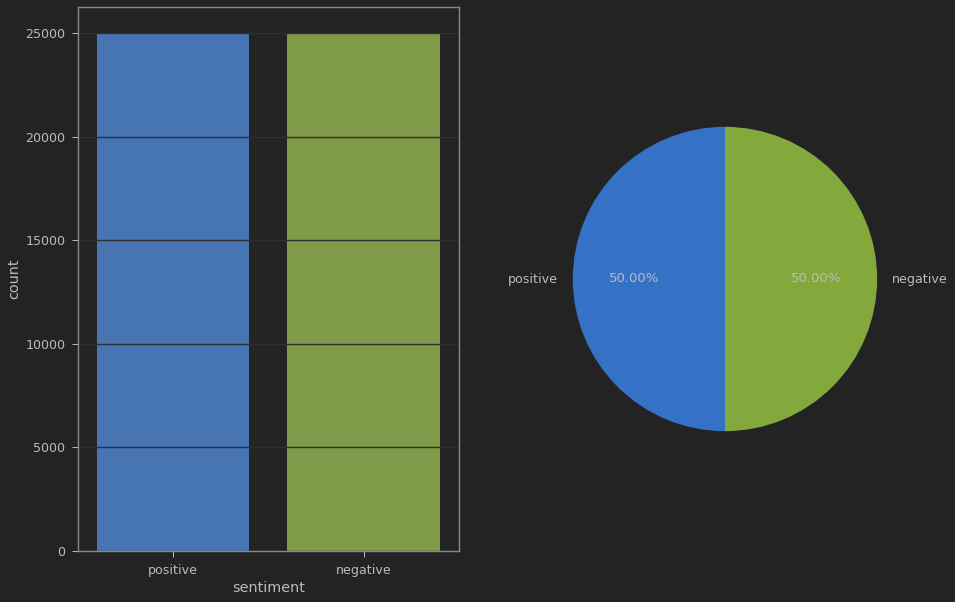

In [ ]:
# Check the distribution of classes
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))

sns.countplot(x="sentiment", data=df, ax=ax[0])

count_labels = [len(np.where(df["sentiment"].values == "positive")[0]), len(np.where(df["sentiment"].values=="negative")[0])]

ax[1].pie(count_labels, labels=["positive", "negative"], autopct="%1.2f%%", startangle=90)
plt.show()

In [ ]:
# Update the sentiment to integer 
#  0 - negative
# 1 - positive

sentiment = {"negative":0, "positive" : 1}
df["sentiment"] = df["sentiment"].apply(lambda x: sentiment[x])
df.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [ ]:
import nltk
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("averaged_perceptron_tagger")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
review = df["review"].values
new_reviews = []

for text in tqdm(review):
    preprocessed_text = preprocess(text, lemmatize=True)
    new_reviews.append(preprocessed_text[0])
    
print(new_reviews[:2])
    


['one reviewer mention watch oz episode hooked right exactly happen me first thing struck oz brutality unflinching scene violence set right word go trust not show faint hearted timid show pull punch regard drug sex violence hardcore classic use word call oz nickname give oswald maximum security state penitentary focus mainly emerald city experimental section prison cell glass front face inwards privacy not high agenda em city home manyaryans muslim gangsta latino christian italian irish scuffle death stare dodgy dealing shady agreement never far away would say main appeal show due fact go show would not dare forget pretty picture paint mainstream audience forget charm forget romance oz not mess around first episode ever saw struck nasty surreal could not say ready watch developed taste oz get accustom high level graphic violence not violence injustice crooked guard sell nickel inmate kill order get away well mannered middle class inmate turn prison bitch due lack street skill prison e

In [ ]:
df["preprocessed_reviews"] = new_reviews
df.head(5)

,review,sentiment,preprocessed_reviews
0,One of the other reviewers has mentioned that ...,1,one reviewer mention watch oz episode hooked r...
1,A wonderful little production. <br /><br />The...,1,wonderful little production film technique una...
2,I thought this was a wonderful way to spend ti...,1,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,0,basically family little boy jake think zombie ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,petter mattei love time money visually stun fi...


In [ ]:
all_reviews = " ".join(df["preprocessed_reviews"].values.tolist())
all_reviews = all_reviews.split()

count_words = Counter(all_reviews)
total_words = len(all_reviews)
sorted_words = count_words.most_common(total_words)
print(f"Top ten words : {sorted_words[:10]}")

Top ten words : [('not', 127771), ('movie', 101496), ('film', 94352), ('one', 54004), ('make', 44219), ('like', 43332), ('see', 41243), ('get', 35037), ('well', 30891), ('time', 30469)]


In [ ]:
word2idx = {word:i+1 for i, (word, count) in enumerate(sorted_words)} # Since 0 is reserved for padding
print(f"Vocabulary Length : {len(word2idx)}")

Vocabulary Length : 125065


In [ ]:
# Encode the reviews

encoded_review = list()
tokenizer = TreebankWordTokenizer()

for review in tqdm(df["preprocessed_reviews"].values):
    tokens = tokenizer.tokenize(review)
    
    _temp = []
    for t in tokens:
        if t in word2idx:
            _temp.append(word2idx[t])
        else:
            _temp.append(0)
            
    encoded_review.append(_temp)

print(encoded_review[:2])


[[4, 993, 315, 13, 2853, 173, 2751, 106, 491, 174, 408, 32, 38, 2863, 2853, 4572, 12240, 21, 457, 93, 106, 259, 14, 1267, 1, 20, 5584, 4829, 9482, 20, 519, 1651, 987, 578, 292, 457, 3324, 224, 69, 259, 150, 2853, 6733, 31, 12473, 5724, 2209, 461, 43959, 511, 1213, 18679, 390, 4079, 1883, 990, 1866, 1736, 797, 207, 43960, 13474, 1, 192, 3763, 7283, 390, 249, 57697, 3557, 10623, 6218, 1163, 851, 2169, 16462, 211, 3587, 6264, 10624, 7220, 6803, 48, 137, 151, 15, 24, 188, 711, 20, 544, 94, 14, 20, 15, 1, 1420, 632, 96, 245, 1453, 2231, 161, 632, 558, 632, 676, 2853, 1, 638, 99, 32, 173, 54, 119, 2863, 1368, 1937, 27, 1, 24, 1379, 13, 1313, 906, 2853, 8, 8230, 192, 423, 1206, 457, 1, 457, 5368, 6051, 1675, 852, 21021, 4530, 100, 415, 8, 151, 9, 8146, 621, 587, 4530, 91, 990, 4645, 544, 258, 554, 1116, 990, 352, 13, 2853, 110, 171, 3257, 2835, 215, 8, 399, 3502, 342], [297, 52, 240, 3, 1508, 57698, 57699, 1069, 31, 3167, 416, 21022, 189, 1638, 335, 236, 45, 440, 9, 57700, 370, 3558, 1, 8, 5

In [ ]:
# Make the encodings of the same size
sequence_length = 250
features = np.zeros((len(encoded_review), sequence_length))

for i, review in tqdm(enumerate(encoded_review)):
    review_len = len(review)
    
    if (review_len <= sequence_length) :
        pad = list(np.zeros(sequence_length - review_len))
        new = pad + review
        
    else:
        new = review[:sequence_length]
        
    features[i, :] = np.array(new)

print(f"Shape of Features Matrix: {features.shape}")


Shape of Features Matrix: (50000, 250)


In [ ]:
X = features
y = df["sentiment"].values

# Split the data into train, val and test set
X_train, temp_x, y_train, temp_y = train_test_split(X, y, test_size=0.3, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(temp_x, temp_y, test_size=0.5, stratify=temp_y)

In [ ]:
print(f"Shape of Train Features : {X_train.shape}")
print(f"Shape of Train Labels : {y_train.shape}")
print("-"*20)
print(f"Shape of Validation Features : {X_val.shape}")
print(f"Shape of Validation Labels : {y_val.shape}")
print("-"*20)
print(f"Shape of Test Features : {X_test.shape}")
print(f"Shape of Test Labels : {y_test.shape}")

Shape of Train Features : (35000, 250)
Shape of Train Labels : (35000,)
--------------------
Shape of Validation Features : (7500, 250)
Shape of Validation Labels : (7500,)
--------------------
Shape of Test Features : (7500, 250)
Shape of Test Labels : (7500,)


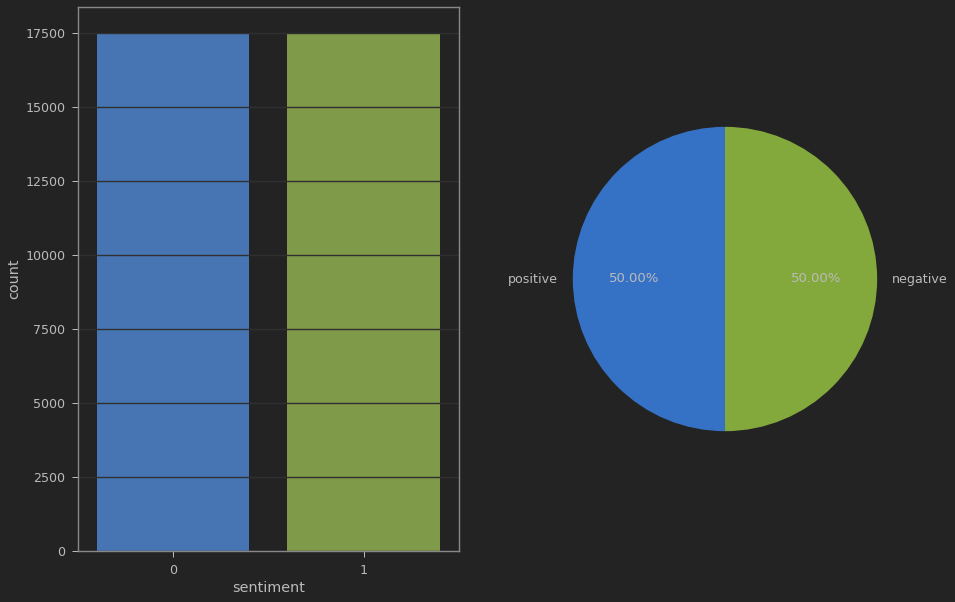

In [ ]:
# Check the distribution of classes
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
df_train = pd.DataFrame({"sentiment":y_train})
sns.countplot(x="sentiment", data=df_train, ax=ax[0])

count_labels = [len(np.where(df_train["sentiment"].values == 1)[0]), len(np.where(df_train["sentiment"].values==0)[0])]

ax[1].pie(count_labels, labels=["positive", "negative"], autopct="%1.2f%%", startangle=90)
plt.show()

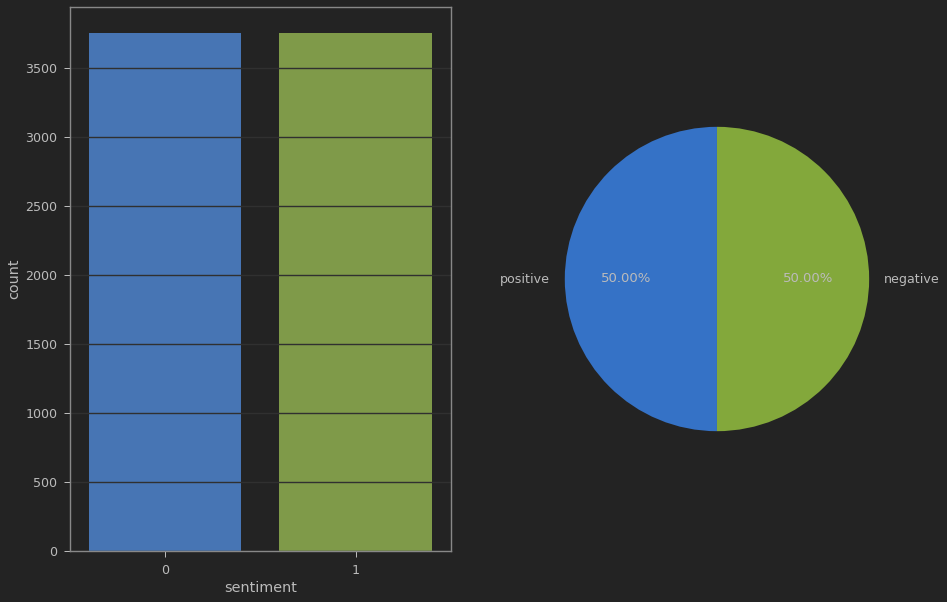

In [ ]:
# Check the distribution of classes
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
df_val = pd.DataFrame({"sentiment":y_val})
sns.countplot(x="sentiment", data=df_val, ax=ax[0])

count_labels = [len(np.where(df_val["sentiment"].values == 1)[0]), len(np.where(df_val["sentiment"].values==0)[0])]

ax[1].pie(count_labels, labels=["positive", "negative"], autopct="%1.2f%%", startangle=90)
plt.show()

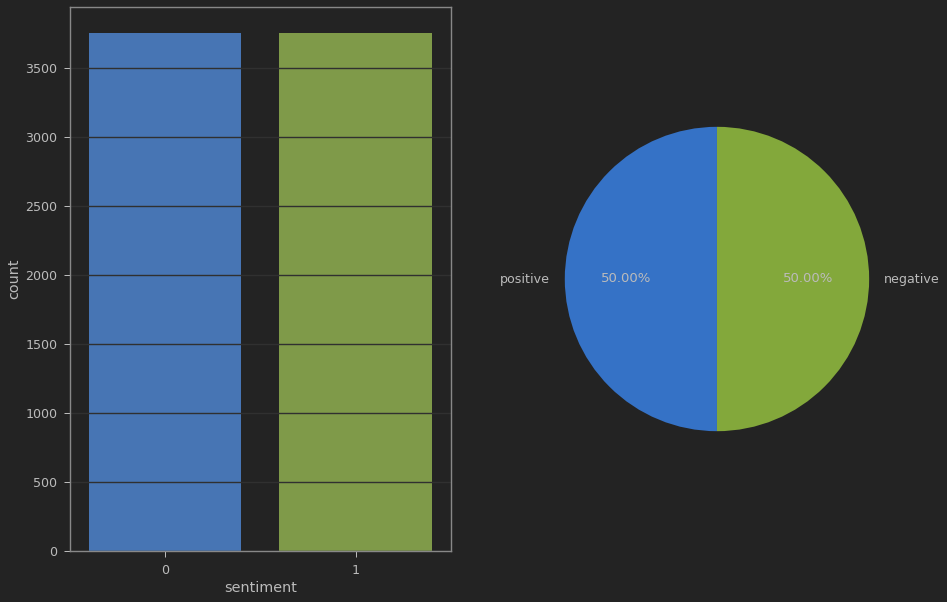

In [ ]:
# Check the distribution of classes
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
df_test = pd.DataFrame({"sentiment":y_val})
sns.countplot(x="sentiment", data=df_test, ax=ax[0])

count_labels = [len(np.where(df_test["sentiment"].values == 1)[0]), len(np.where(df_test["sentiment"].values==0)[0])]

ax[1].pie(count_labels, labels=["positive", "negative"], autopct="%1.2f%%", startangle=90)
plt.show()

In [ ]:
# Create Tensor Datasets
train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_train).long(), torch.from_numpy(y_train).float())
val_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_val).long(), torch.from_numpy(y_val).float())
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_test).long(), torch.from_numpy(y_test).float())

# Create batch iterators
batch_size = 64
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_iter = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=False)

# PyTorch Model

In [ ]:
class SentimentClassifier(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, n_hidden, n_layers, n_classes, embedding_mat, bidirectional=False,dropout_rate=0.3):
        
        super(SentimentClassifier, self).__init__()
        self.V = vocab_size
        self.D = embedding_dim
        self.H = n_hidden
        self.L = n_layers
        self.O = n_classes
        self.bidirectional = bidirectional
        
        self.embedding = nn.Embedding(self.V, self.D)
        self.embedding.weight = nn.Parameter(embedding_mat, requires_grad=False)
        self.lstm = nn.LSTM(self.D, self.H, self.L, dropout=dropout_rate, batch_first=True, bidirectional=self.bidirectional)
        self.dropout = nn.Dropout(dropout_rate)
        if not self.bidirectional:
          self.fc = nn.Sequential(nn.ReLU(),
                                nn.Linear(self.H*2, 64),
                                nn.ReLU(),
                                nn.Dropout(dropout_rate),
                                nn.Linear(64, 16),
                                nn.ReLU(),
                                nn.Dropout(dropout_rate),
                                nn.Linear(16, self.O),
                                nn.Sigmoid())
        else:
          self.fc = nn.Sequential(nn.ReLU(),
                              nn.Linear(self.H*4, 64),
                              nn.ReLU(),
                              nn.Dropout(dropout_rate),
                              nn.Linear(64, 16),
                              nn.ReLU(),
                              nn.Dropout(dropout_rate),
                              nn.Linear(16, self.O),
                              nn.Sigmoid())
        
    def forward(self, X):
        if self.bidirectional:
          h0, c0 = torch.zeros(self.L*2, X.size(0), self.H).to(device), torch.zeros(self.L*2, X.size(0), self.H).to(device)
        else:
          h0, c0 = torch.zeros(self.L, X.size(0), self.H).to(device), torch.zeros(self.L, X.size(0), self.H).to(device)
        
        out = self.embedding(X)
        out, (h,c) = self.lstm(out, (h0, c0))
        avg_pool = torch.mean(out, 1)
        max_pool, _ = torch.max(out, 1)
        conc = torch.cat((avg_pool, max_pool), 1)
        out = self.fc(conc)
        return out
    

In [ ]:
torch.cuda.empty_cache()

In [ ]:
def read_glove(dim=300):
    
    file_name = f"glove.6B.{dim}d.txt"
    
    glove = {}
    
    for lines in tqdm(open(f"./DATA/{file_name}", "r")):
        
        lines = lines.split()
        glove[lines[0]] = np.array(lines[1:]).astype(np.float)
        
        
    return glove

def get_glove_mat(glove, vocab, dim=300):
    
    weights = np.zeros((len(vocab)+1, dim))
    
    for words, i in vocab.items():
        if words in glove:
            weights[i] = glove[words]
        else:
            weights[i] = np.random.normal(size=(dim,))
    
    return weights

In [ ]:
vocab_size = len(word2idx) + 1
glove = read_glove()

embedding_mat = get_glove_mat(glove, word2idx)

embedding_mat = torch.from_numpy(embedding_mat.astype(np.float32))

In [ ]:
embedding_dim = 300
n_hidden = 128
n_layers = 2
n_classes = 1

model = SentimentClassifier(vocab_size, embedding_dim, n_hidden, n_layers, n_classes, embedding_mat, dropout_rate=0.3)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(model)
print(f"Device used :{device}")

SentimentClassifier(
  (embedding): Embedding(125066, 300)
  (lstm): LSTM(300, 128, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Sequential(
    (0): ReLU()
    (1): Linear(in_features=256, out_features=64, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=64, out_features=16, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.3, inplace=False)
    (7): Linear(in_features=16, out_features=1, bias=True)
    (8): Sigmoid()
  )
)
Device used :cuda:0


In [ ]:
model2 = SentimentClassifier(vocab_size, embedding_dim, n_hidden, n_layers, n_classes, embedding_mat, bidirectional=True,dropout_rate=0.3)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model2 = model2.to(device)
print(model2)
print(f"Device used :{device}")

SentimentClassifier(
  (embedding): Embedding(125066, 300)
  (lstm): LSTM(300, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Sequential(
    (0): ReLU()
    (1): Linear(in_features=512, out_features=64, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=64, out_features=16, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.3, inplace=False)
    (7): Linear(in_features=16, out_features=1, bias=True)
    (8): Sigmoid()
  )
)
Device used :cuda:0


In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
criterion2 = nn.BCELoss()
optimizer2 = torch.optim.Adam(model2.parameters(), lr=1e-4)

In [ ]:
def batch_gd(model, criterion, optimizer, train_iter, val_iter, epochs=20):
    
    """
    --------------------------------------------------
    Description : Function to calculate batch gradient descent
    
    Parameters :
    @param model -- a pytorch model
    @param criterion -- a pytorch loss function
    @param optimizer -- a pytorch optimizer
    @param train_iter -- a pytorch dataloader representing training data
    @param val_iter -- a pytorch dataloader representing validation data or test data
    @epochs -- an integer representing number of epochs (default=20)
    
    Return :
    @ret train_losses -- the training loss
    @ret val_losses -- the validation loss / test loss
    @ret train_accuracy -- training accuracy
    @ret val_accuracy -- validation accuracy / test accuracy
    --------------------------------------------------
    
    """
    
    train_losses = np.zeros(epochs)
    val_losses = np.zeros(epochs)
    
    train_accuracy = np.zeros(epochs)
    val_accuracy = np.zeros(epochs)
    
    for epoch in range(epochs):
        
        train_loss = []
        train_acc = []
        model.train()
        for inputs, targets in tqdm(train_iter):
            
            # Move inputs and targets to device
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Reshape the targets for BCEWithLogitsLoss
            targets = targets.view(-1, 1)
            
            # Zero the gradients of the optimizer
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            # loss = criterion(outputs.view(-1, 1), targets)
            loss = criterion(outputs, targets)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Track the loss
            train_loss.append(loss.item())
            
            # Calculate the accuracy of the model and track it
            
            predictions = np.round(outputs.cpu().detach().numpy())
            acc = np.mean(targets.cpu().numpy() == predictions)
            
            train_acc.append(acc)
            
        
        val_loss = []
        val_acc = []
        model.eval()
            
        for inputs, targets in tqdm(val_iter):
            
            # Move inputs and targets to device
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Reshape the target for BCEWithLogitsLoss
            targets = targets.view(-1, 1)
            
            # Forward pass
            outputs = model(inputs)
            # loss = criterion(outputs.view(-1,1), targets)
            loss = criterion(outputs, targets)
            # Track the loss
            val_loss.append(loss.item())
            
            # Calculate the accuracy and track it
            predictions = np.round(outputs.cpu().detach().numpy())
            acc = np.mean(targets.cpu().numpy() == predictions)
            
            val_acc.append(acc)
            
        train_loss = np.mean(train_loss)
        val_loss = np.mean(val_loss)
        
        train_acc = np.mean(train_acc)
        val_acc = np.mean(val_acc)
        
        train_losses[epoch] = train_loss
        val_losses[epoch] = val_loss
        
        train_accuracy[epoch] = train_acc
        val_accuracy[epoch] = val_acc
        
        print(f"Epoch : {epoch+1}/{epochs} | Train Loss : {train_loss} , Train Acc : {train_acc}| Val Loss : {val_loss}, Val Accuracy: {val_acc}")
        
    
    return train_losses, val_losses, train_accuracy, val_accuracy
    

In [ ]:
torch.cuda.empty_cache()

In [ ]:
train_losses, val_losses, train_acc, val_acc = batch_gd(model, criterion, optimizer, train_iter, val_iter, epochs=15)


Epoch : 1/15 | Train Loss : 0.5941761226497141 , Train Acc : 0.6820196200052232| Val Loss : 0.44692452403448396, Val Accuracy: 0.8034074858757062



Epoch : 2/15 | Train Loss : 0.43090830528104107 , Train Acc : 0.8141526834682685| Val Loss : 0.39579598428839347, Val Accuracy: 0.8295374293785311



Epoch : 3/15 | Train Loss : 0.39206995080877266 , Train Acc : 0.8349642530686864| Val Loss : 0.36398903419405726, Val Accuracy: 0.8435293079096045



Epoch : 4/15 | Train Loss : 0.3711093563375351 , Train Acc : 0.8439907612953774| Val Loss : 0.3449687712778479, Val Accuracy: 0.8546080508474576



Epoch : 5/15 | Train Loss : 0.3576987225841561 , Train Acc : 0.8524541329328806| Val Loss : 0.33445257201033124, Val Accuracy: 0.8590660310734464



Epoch : 6/15 | Train Loss : 0.3410754544316524 , Train Acc : 0.8613378166623139| Val Loss : 0.33621897396899886, Val Accuracy: 0.8541666666666667



Epoch : 7/15 | Train Loss : 0.327666352719232 , Train Acc : 0.8684137503264561| Val Loss : 0.31217186872736885, Val Accuracy: 0.8698799435028248



Epoch : 8/15 | Train Loss : 0.31746395264617705 , Train Acc : 0.8713232893705928| Val Loss : 0.3092497267712981, Val Accuracy: 0.8724399717514125



Epoch : 9/15 | Train Loss : 0.30644093354452245 , Train Acc : 0.8777830373465657| Val Loss : 0.3058856316542221, Val Accuracy: 0.8723516949152542



Epoch : 10/15 | Train Loss : 0.2934274546243591 , Train Acc : 0.8832797401410291| Val Loss : 0.31122378941814777, Val Accuracy: 0.8697916666666667



Epoch : 11/15 | Train Loss : 0.28396639951131897 , Train Acc : 0.8880949660485766| Val Loss : 0.2972164267074254, Val Accuracy: 0.875



Epoch : 12/15 | Train Loss : 0.27296177108501385 , Train Acc : 0.8948362823191434| Val Loss : 0.30089071834996595, Val Accuracy: 0.875882768361582



Epoch : 13/15 | Train Loss : 0.26398724504155696 , Train Acc : 0.8979743405588927| Val Loss : 0.3080303860922991, Val Accuracy: 0.8733227401129943



Epoch : 14/15 | Train Loss : 0.2583447057597162 , Train Acc : 0.9013409179942543| Val Loss : 0.31431931168851207, Val Accuracy: 0.8700123587570621



Epoch : 15/15 | Train Loss : 0.2455857210610423 , Train Acc : 0.9074048380778271| Val Loss : 0.2921645044017646, Val Accuracy: 0.8812676553672316


In [ ]:
torch.cuda.empty_cache()

In [ ]:
train_losses2, val_losses2, train_acc2, val_acc2 = batch_gd(model2, criterion2, optimizer2, train_iter, val_iter, epochs=15)


Epoch : 1/15 | Train Loss : 0.5433714861080895 , Train Acc : 0.7198640310786106| Val Loss : 0.39294524263527436, Val Accuracy: 0.8283456920903955



Epoch : 2/15 | Train Loss : 0.4029879277160006 , Train Acc : 0.8320873596239227| Val Loss : 0.354446334101386, Val Accuracy: 0.8512976694915254



Epoch : 3/15 | Train Loss : 0.36716626091456717 , Train Acc : 0.8473899843301124| Val Loss : 0.34978483137437855, Val Accuracy: 0.8476341807909604



Epoch : 4/15 | Train Loss : 0.3486443862346234 , Train Acc : 0.8526214416296682| Val Loss : 0.335323374023882, Val Accuracy: 0.856152895480226



Epoch : 5/15 | Train Loss : 0.33373546998069314 , Train Acc : 0.8625130582397493| Val Loss : 0.31764154754957913, Val Accuracy: 0.8631709039548023



Epoch : 6/15 | Train Loss : 0.3175022694157944 , Train Acc : 0.8701480477931575| Val Loss : 0.3043372147416664, Val Accuracy: 0.8718661723163842



Epoch : 7/15 | Train Loss : 0.3045876390373903 , Train Acc : 0.8752856489945156| Val Loss : 0.3044793162558038, Val Accuracy: 0.8696151129943502



Epoch : 8/15 | Train Loss : 0.2944738033212299 , Train Acc : 0.8818066074693132| Val Loss : 0.3087209446702973, Val Accuracy: 0.8674523305084746



Epoch : 9/15 | Train Loss : 0.28318343864552936 , Train Acc : 0.8876134434578219| Val Loss : 0.2937564601079892, Val Accuracy: 0.8774276129943502



Epoch : 10/15 | Train Loss : 0.27094986154893635 , Train Acc : 0.8932896970488378| Val Loss : 0.3171800470958322, Val Accuracy: 0.8697033898305084



Epoch : 11/15 | Train Loss : 0.2615443047755815 , Train Acc : 0.8975417863671976| Val Loss : 0.2905238832710153, Val Accuracy: 0.8787517655367231



Epoch : 12/15 | Train Loss : 0.24515092996727178 , Train Acc : 0.9036954818490467| Val Loss : 0.29072898064376945, Val Accuracy: 0.881885593220339



Epoch : 13/15 | Train Loss : 0.2384543892888308 , Train Acc : 0.906776410289893| Val Loss : 0.3247514242716765, Val Accuracy: 0.868997175141243



Epoch : 14/15 | Train Loss : 0.2247178671265215 , Train Acc : 0.913958442151998| Val Loss : 0.2960904169259435, Val Accuracy: 0.8811352401129943



Epoch : 15/15 | Train Loss : 0.21103275876485453 , Train Acc : 0.9211404740141029| Val Loss : 0.29993654743342074, Val Accuracy: 0.8825476694915254


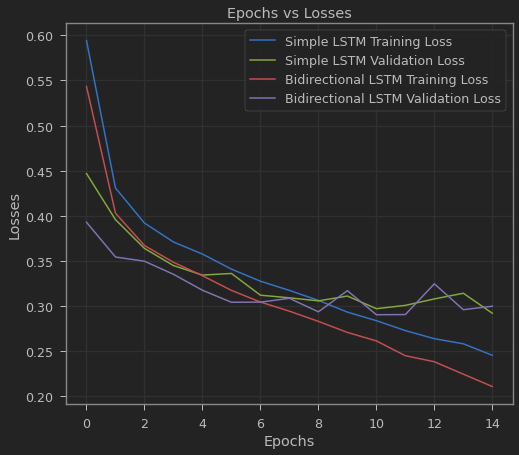

In [ ]:
plt.title("Epochs vs Losses")
plt.plot(train_losses, label="Simple LSTM Training Loss")
plt.plot(val_losses, label="Simple LSTM Validation Loss")
plt.plot(train_losses2, label="Bidirectional LSTM Training Loss")
plt.plot(val_losses2, label="Bidirectional LSTM Validation Loss")
plt.plot()
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend()
plt.show()

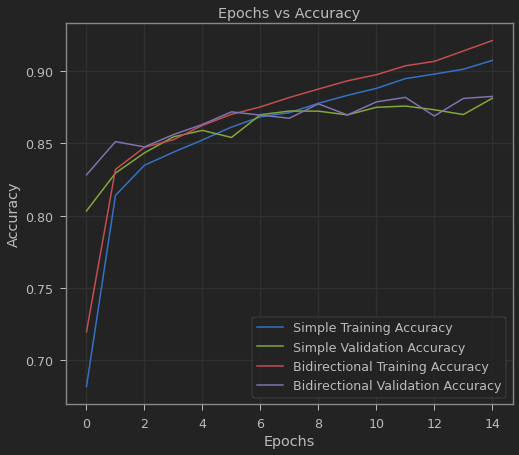

In [ ]:
plt.title("Epochs vs Accuracy")
plt.plot(train_acc, label="Simple Training Accuracy")
plt.plot(val_acc, label="Simple Validation Accuracy")
plt.plot(train_acc2, label="Bidirectional Training Accuracy")
plt.plot(val_acc2, label="Bidirectional Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
def test_set_grader(mymodel, criterion, test_iter):
    
    test_loss = []
    test_acc = []
    mymodel.eval()
    y_pred = []
    for inputs, targets in tqdm(test_iter):
        
        inputs, targets = inputs.to(device), targets.to(device)
        targets = targets.view(-1, 1)
        
        outputs = mymodel(inputs)
        loss = criterion(outputs, targets)
        
        predictions = np.round(outputs.cpu().detach().numpy())
        acc = np.mean(targets.cpu().detach().numpy() == predictions)
        y_pred.extend(predictions.reshape(-1, ))
        
        test_loss.append(loss.item())
        test_acc.append(acc)
        
    print(f"Test Loss : {np.mean(test_loss)} | Test Acc : {np.mean(test_acc)}")
    return y_pred

In [ ]:
torch.cuda.empty_cache()

In [ ]:
y_pred = test_set_grader(model, criterion, test_iter)


Test Loss : 0.31015096911787987 | Test Acc : 0.8736


In [ ]:
torch.cuda.empty_cache()

In [ ]:
y_pred2 = test_set_grader(model2, criterion2, test_iter)


Test Loss : 0.3066691513977324 | Test Acc : 0.8765333333333335


In [ ]:
print("Confusion Matrix for Simple LSTM")
print(confusion_matrix(y_test, y_pred))
print("-"*20)
print("Classification Metrics for Simple LSTM")
print(classification_report(y_test, y_pred))

Confusion Matrix for Simple LSTM
[[3254  496]
 [ 452 3298]]
--------------------
Classification Metrics for Simple LSTM
              precision    recall  f1-score   support

           0       0.88      0.87      0.87      3750
           1       0.87      0.88      0.87      3750

    accuracy                           0.87      7500
   macro avg       0.87      0.87      0.87      7500
weighted avg       0.87      0.87      0.87      7500



In [ ]:
print("Confusion Matrix for Bi-directional LSTM")
print(confusion_matrix(y_test, y_pred2))
print("-"*20)
print("Classification Metrics for Bi-directional LSTM")
print(classification_report(y_test, y_pred2))

Confusion Matrix for Bi-directional LSTM
[[3309  441]
 [ 485 3265]]
--------------------
Classification Metrics for Bi-directional LSTM
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      3750
           1       0.88      0.87      0.88      3750

    accuracy                           0.88      7500
   macro avg       0.88      0.88      0.88      7500
weighted avg       0.88      0.88      0.88      7500



In [ ]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)
AUC = roc_auc_score(y_test, y_pred)
print(f"AUC Score for Simple LSTM: {AUC}")

AUC Score for Simple LSTM: 0.8735999999999999


In [ ]:
fpr2, tpr2, threshold2 = roc_curve(y_test, y_pred2)
AUC = roc_auc_score(y_test, y_pred2)
print(f"AUC Score for Bi-directional LSTM: {AUC}")

AUC Score for Bi-directional LSTM: 0.8765333333333333


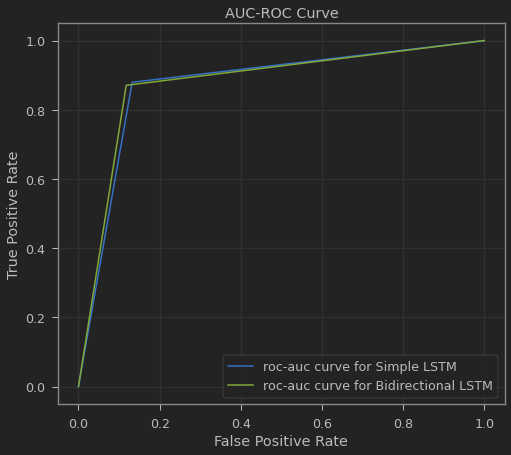

In [ ]:
plt.title("AUC-ROC Curve")
plt.plot(fpr, tpr, label="roc-auc curve for Simple LSTM")
plt.plot(fpr2, tpr2, label="roc-auc curve for Bidirectional LSTM")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [ ]:
torch.save({"model":model.state_dict(),
            "optimizer":optimizer.state_dict()}, "/content/drive/My Drive/lstm_model.pt")

In [ ]:
torch.save({"model_bidirectional":model2.state_dict(),
            "optimizer_bidirectional":optimizer2.state_dict()}, "/content/drive/My Drive/lstm_bidirectional_model.pt")

In [ ]:
with open("/content/drive/My Drive/vocabulary.json", "w") as fp:
  json.dump(word2idx, fp)

In [ ]:
with open("/content/drive/My Drive/features.npz", "wb") as fp:
  np.save(fp, embedding_mat.numpy())